In [2]:
# If needed (uncomment in Colab):
# !pip install -q kagglehub tensorflow pandas scikit-learn

import os, re, json, warnings, random
from pathlib import Path
import numpy as np
import pandas as pd

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Settings
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
WARMUP_EPOCHS = 3
FINE_TUNE_EPOCHS = 12
USE_CLASS_WEIGHTS = False  # start disabled; avoids "everything positive" bias
CHECKPOINT_PATH = "best_dr_binary.keras"
META_PATH = "dr_model_meta.json"

# Download dataset via KaggleHub
import kagglehub
print("Downloading dataset via KaggleHub...")
path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")
print("Path to dataset files:", path)

dataset_root = Path(path)
if not dataset_root.exists():
    raise FileNotFoundError(f"Dataset path not found: {dataset_root}")


Using Colab cache for faster access to the 'eye-diseases-classification' dataset.
Path to dataset files: /kaggle/input/eye-diseases-classification


In [3]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def is_image(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def is_positive_class_folder(name: str) -> bool:
    # Positive if folder suggests "diabetic retinopathy"
    n = name.lower()
    return ("diabet" in n) or (n == "dr") or ("retinopathy" in n)

files = [p for p in dataset_root.rglob("*") if is_image(p)]
if not files:
    raise RuntimeError(f"No images found under {dataset_root}. Inspect dataset structure.")

rows = []
for p in files:
    cls = p.parent.name
    label = 1 if is_positive_class_folder(cls) else 0
    rows.append((str(p), cls, label))

df = pd.DataFrame(rows, columns=["filepath", "class_name", "label"])
print("Total images:", len(df))
print("\nPer-folder counts:")
print(
    df.groupby(["class_name","label"])
      .size()
      .rename("count")
      .reset_index()
      .sort_values("count", ascending=False)
      .to_string(index=False)
)
print("\nBinary balance:\n", df["label"].value_counts())


Total images: 4217

Per-folder counts:
          class_name  label  count
diabetic_retinopathy      1   1098
              normal      0   1074
            cataract      0   1038
            glaucoma      0   1007

Binary balance:
 label
0    3119
1    1098
Name: count, dtype: int64


In [4]:
from sklearn.model_selection import train_test_split

test_size = 0.15
val_size  = 0.15

df_trainval, df_test = train_test_split(
    df, test_size=test_size, random_state=SEED, stratify=df["label"]
)
rel_val = val_size / (1.0 - test_size)
df_train, df_val = train_test_split(
    df_trainval, test_size=rel_val, random_state=SEED, stratify=df_trainval["label"]
)

print(f"Splits -> train: {len(df_train)}, val: {len(df_val)}, test: {len(df_test)}")
print(f"Val positive prevalence: {df_val['label'].mean():.4f}")


Splits -> train: 2951, val: 633, test: 633
Val positive prevalence: 0.2607


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

def load_image_and_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img, tf.cast(label, tf.float32)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.1),
])

def make_ds(df_part, training=True):
    paths  = df_part["filepath"].values
    labels = df_part["label"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(df_part), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image_and_label, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(df_train, training=True)
val_ds   = make_ds(df_val, training=False)
test_ds  = make_ds(df_test, training=False)

# Class weights suggestion (disabled by default)
neg = int((df_train["label"] == 0).sum())
pos = int((df_train["label"] == 1).sum())
total = max(1, neg + pos)
class_weight = {0: total / (2.0 * max(neg,1)), 1: total / (2.0 * max(pos,1))}
print("Suggested class weights:", class_weight)

if not USE_CLASS_WEIGHTS:
    class_weight = None
    print("Class weights DISABLED.")


Suggested class weights: {0: 0.6759047182775997, 1: 1.9212239583333333}
Class weights DISABLED.


In [6]:
from tensorflow.keras import layers, models

def build_cnn(input_shape=(224,224,3)):
    inp = layers.Input(shape=input_shape)
    x = inp
    for f in [32, 64, 128]:
        x = layers.Conv2D(f, 3, padding="same", use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    return models.Model(inp, out, name="dr_binary_cnn")

def build_efficientnet_b0(input_shape=(224,224,3)):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.applications.efficientnet import preprocess_input
    inp = layers.Input(shape=input_shape)
    x = layers.Lambda(lambda t: preprocess_input(t * 255.0))(inp)
    base = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = models.Model(inp, out, name="dr_efficientnet_b0")
    return model, base

use_efficientnet = True
base = None
base_name = "efficientnet"

try:
    model, base = build_efficientnet_b0(IMG_SIZE + (3,))
except Exception as e:
    warnings.warn(f"Falling back to small CNN due to: {e}")
    model = build_cnn(IMG_SIZE + (3,))
    use_efficientnet = False
    base_name = "smallcnn"

metrics = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=metrics)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "dr_efficientnet_b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ lambda[0][0]      │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [7]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        CHECKPOINT_PATH, monitor="val_auc_pr", mode="max",
        save_best_only=True, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc_pr", mode="max",
        patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    ),
]

if use_efficientnet and base is not None:
    # Warm-up: freeze backbone
    base.trainable = False
    print("\n== Warm-up training (frozen EfficientNet) ==")
    history1 = model.fit(
        train_ds, validation_data=val_ds,
        epochs=WARMUP_EPOCHS, class_weight=class_weight,
        callbacks=callbacks, verbose=1
    )

    # Fine-tune: unfreeze backbone (you can unfreeze partially if you prefer)
    base.trainable = True
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss="binary_crossentropy", metrics=metrics)
    print("\n== Fine-tuning EfficientNet ==")
    history2 = model.fit(
        train_ds, validation_data=val_ds,
        epochs=FINE_TUNE_EPOCHS, class_weight=class_weight,
        callbacks=callbacks, verbose=1
    )
else:
    print("\n== Training small CNN ==")
    history = model.fit(
        train_ds, validation_data=val_ds,
        epochs=WARMUP_EPOCHS + FINE_TUNE_EPOCHS, class_weight=class_weight,
        callbacks=callbacks, verbose=1
    )

# Load best weights found on validation set
if os.path.exists(CHECKPOINT_PATH):
    model.load_weights(CHECKPOINT_PATH)
    print(f"Loaded best weights from {CHECKPOINT_PATH}")



== Warm-up training (frozen EfficientNet) ==
Epoch 1/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7792 - auc: 0.7558 - auc_pr: 0.6014 - loss: 0.4745 - precision: 0.7021 - recall: 0.3232
Epoch 1: val_auc_pr improved from -inf to 0.90450, saving model to best_dr_binary.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.7799 - auc: 0.7570 - auc_pr: 0.6032 - loss: 0.4734 - precision: 0.7039 - recall: 0.3246 - val_accuracy: 0.9036 - val_auc: 0.9584 - val_auc_pr: 0.9045 - val_loss: 0.3028 - val_precision: 0.8059 - val_recall: 0.8303 - learning_rate: 0.0010
Epoch 2/3
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8889 - auc: 0.9419 - auc_pr: 0.8807 - loss: 0.2662 - precision: 0.8881 - recall: 0.6343
Epoch 2: val_auc_pr improved from 0.90450 to 0.92294, saving model to best_dr_binary.keras
93/93 ━━━━━━━━━━━━━━━━━━━━ 371s 4s/step - accuracy: 0.8889 - auc: 0.9419 - auc_pr: 0.8808 - loss: 0.2661 - precision: 0.8882 - recall: 0.6347 - val_accuracy: 0.8831 - val_auc: 0.9674 

KeyboardInterrupt: 

In [9]:
CHECKPOINT_PATH = "best_dr_binary.keras"
model.load_weights(CHECKPOINT_PATH)
print("Loaded best checkpoint:", CHECKPOINT_PATH)



Loaded best checkpoint: best_dr_binary.keras


In [11]:
model.load_weights("best_dr_binary.keras")
print("Loaded best checkpoint.")



Loaded best checkpoint.


In [12]:
import os
CHECKPOINT_PATH = "best_dr_binary.keras"
print("Exists?", os.path.exists(CHECKPOINT_PATH), CHECKPOINT_PATH)


Exists? True best_dr_binary.keras


In [13]:
# If this raises NameError, you restarted the kernel → run Cell 5 first.
_ = model


In [14]:
from sklearn.metrics import (
    roc_auc_score, accuracy_score, balanced_accuracy_score,
    confusion_matrix, classification_report, f1_score, precision_recall_fscore_support
)
import numpy as np

def collect_probs(ds, mdl):
    y_true, y_prob = [], []
    for xb, yb in ds:
        y_true.extend(yb.numpy().tolist())
        y_prob.extend(mdl.predict(xb, verbose=0).ravel().tolist())
    return np.array(y_true, dtype=int), np.array(y_prob, dtype=float)

# Validation metrics at threshold 0.5
y_true_val, y_prob_val = collect_probs(val_ds, model)
y_pred_val_05 = (y_prob_val >= 0.5).astype(int)

print("== Validation @ 0.5 threshold ==")
print("AUC(ROC):", roc_auc_score(y_true_val, y_prob_val))
print("Accuracy:", accuracy_score(y_true_val, y_pred_val_05))
print("Balanced Acc:", balanced_accuracy_score(y_true_val, y_pred_val_05))
print("Confusion [rows=true NotDR,DR; cols=pred]:\n",
      confusion_matrix(y_true_val, y_pred_val_05))
print(classification_report(y_true_val, y_pred_val_05, target_names=["Not DR","DR"]))

# F1s
f1_val_pos = f1_score(y_true_val, y_pred_val_05, zero_division=0)  # DR class
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_val, y_pred_val_05, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_val, y_pred_val_05, average="weighted", zero_division=0
)
print(f"F1 (pos=DR) @0.5: {f1_val_pos:.4f}")
print(f"F1 macro @0.5: {f1_macro:.4f}  |  F1 weighted @0.5: {f1_weighted:.4f}")


== Validation @ 0.5 threshold ==
AUC(ROC): 0.9965034965034965
Accuracy: 0.9842022116903634
Balanced Acc: 0.9853923853923854
Confusion [rows=true NotDR,DR; cols=pred]:
 [[460   8]
 [  2 163]]
              precision    recall  f1-score   support

      Not DR       1.00      0.98      0.99       468
          DR       0.95      0.99      0.97       165

    accuracy                           0.98       633
   macro avg       0.97      0.99      0.98       633
weighted avg       0.98      0.98      0.98       633

F1 (pos=DR) @0.5: 0.9702
F1 macro @0.5: 0.9797  |  F1 weighted @0.5: 0.9843


In [15]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_recall_fscore_support, \
                            accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix
import numpy as np

# Ensure validation probs exist
try:
    y_true_val, y_prob_val
except NameError:
    y_true_val, y_prob_val = collect_probs(val_ds, model)

# 1) Exact max-F1 threshold from PR curve
prec, rec, thr = precision_recall_curve(y_true_val, y_prob_val)  # thr has length len(prec)-1
f1s = (2 * prec * rec) / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1s))
# Align PR arrays: choose nearby threshold index
best_thr_exact = float(thr[max(best_idx - 1, 0)]) if best_idx < len(thr) else 0.5
print(f"[Val] Max-F1 ≈ {f1s[best_idx]:.4f} at threshold ≈ {best_thr_exact:.4f}")
print(f"[Val] Precision={prec[best_idx]:.4f}  Recall={rec[best_idx]:.4f}")

# 2) Optional: threshold to hit a target recall
target_recall = 0.90
eligible = np.where(rec[:-1] >= target_recall)[0]  # align with thr size
if len(eligible):
    idx_tr = eligible[np.argmax(prec[eligible])]    # highest precision among those with >= target recall
    thr_tr = float(thr[idx_tr])
    print(f"[Val] Target recall ≥{target_recall:.2f}: thr ≈ {thr_tr:.4f} "
          f"(prec={prec[idx_tr]:.4f}, rec={rec[idx_tr]:.4f})")
else:
    thr_tr = None
    print(f"[Val] Could not reach recall ≥{target_recall:.2f} on validation.")

# Helper: evaluate on test at a given threshold
def eval_on_test(threshold, name):
    y_true_test, y_prob_test = collect_probs(test_ds, model)
    y_pred_test = (y_prob_test >= threshold).astype(int)
    f1_pos = f1_score(y_true_test, y_pred_test, zero_division=0)
    pm, rm, f1m, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average="macro", zero_division=0)
    pw, rw, f1w, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average="weighted", zero_division=0)
    print(f"\n== Test @ {name} (thr={threshold:.4f}) ==")
    print("AUC(ROC):", roc_auc_score(y_true_test, y_prob_test))
    print("Accuracy:", accuracy_score(y_true_test, y_pred_test))
    print("Balanced Acc:", balanced_accuracy_score(y_true_test, y_pred_test))
    print("Confusion [rows=true NotDR,DR; cols=pred]:\n", confusion_matrix(y_true_test, y_pred_test))
    print(f"F1 (pos=DR): {f1_pos:.4f} | F1 macro: {f1m:.4f} | F1 weighted: {f1w:.4f}")

# Evaluate at max-F1 threshold
eval_on_test(best_thr_exact, "max-F1")

# Evaluate at target-recall threshold (if available)
if thr_tr is not None:
    eval_on_test(thr_tr, f"rec≥{target_recall:.2f}")


[Val] Max-F1 ≈ 0.9756 at threshold ≈ 0.7307
[Val] Precision=0.9816  Recall=0.9697
[Val] Target recall ≥0.90: thr ≈ 0.8721 (prec=0.9868, rec=0.9030)

== Test @ max-F1 (thr=0.7307) ==
AUC(ROC): 0.9994042994042994
Accuracy: 0.9842022116903634
Balanced Acc: 0.9736208236208237
Confusion [rows=true NotDR,DR; cols=pred]:
 [[466   2]
 [  8 157]]
F1 (pos=DR): 0.9691 | F1 macro: 0.9793 | F1 weighted: 0.9841

== Test @ rec≥0.90 (thr=0.8721) ==
AUC(ROC): 0.9994042994042994
Accuracy: 0.976303317535545
Balanced Acc: 0.9545454545454546
Confusion [rows=true NotDR,DR; cols=pred]:
 [[468   0]
 [ 15 150]]
F1 (pos=DR): 0.9524 | F1 macro: 0.9683 | F1 weighted: 0.9759


In [16]:

import json, os
from pathlib import Path
import tensorflow as tf
import pandas as pd

best_thr_exact = 0.7307

meta = {
    "threshold": float(best_thr_exact),
    "label_positive_desc": "Diabetic Retina (DR)",
    "label_negative_desc": "Not DR",
    "img_size": IMG_SIZE,
    "base_model": base_name if 'base_name' in globals() else "unknown",
}
with open("dr_model_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved tuned threshold/meta to dr_model_meta.json")

# 3) Inference helpers
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def predict_image_paths(image_paths, threshold=None):
    if threshold is None:
        threshold = meta["threshold"]
    outs = []
    for p in image_paths:
        img = tf.io.read_file(p)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, IMG_SIZE)
        prob = float(model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0])
        outs.append({"path": str(p), "prob_DR": prob, "pred_DR": int(prob >= threshold)})
    return outs

def predict_folder(folder_path, threshold=None, save_csv=True, csv_path="dr_predictions.csv"):
    folder = Path(folder_path)
    files = [p for p in folder.rglob("*") if p.suffix.lower() in IMG_EXTS]
    if not files:
        print(f"No images found under {folder.resolve()}")
        return pd.DataFrame()
    preds = predict_image_paths(files, threshold)
    df_preds = pd.DataFrame(preds)
    if save_csv:
        df_preds.to_csv(csv_path, index=False)
        print(f"Saved predictions to {csv_path}  (threshold={threshold if threshold else meta['threshold']:.4f})")
    return df_preds

print(f"Ready. Using threshold={best_thr_exact:.4f} (max-F1).")


Saved tuned threshold/meta to dr_model_meta.json
Ready. Using threshold=0.7307 (max-F1).


In [19]:
# === Save models (.keras, .h5), SavedModel (robust), and metadata ===
import os, json, tensorflow as tf

EXPORT_DIR = "export_dr_model"
os.makedirs(EXPORT_DIR, exist_ok=True)

# Ensure a threshold is set (use your chosen one)
if 'best_thr_exact' not in globals():
    best_thr_exact = 0.7307  # recommended balanced operating point

# 1) Native Keras format
KERAS_PATH = os.path.join(EXPORT_DIR, "dr_classifier.keras")
model.save(KERAS_PATH)
print("Saved:", KERAS_PATH)

# 2) HDF5 format (.h5) — legacy but okay if you need it
H5_PATH = os.path.join(EXPORT_DIR, "dr_classifier.h5")
try:
    model.save(H5_PATH)  # saves HDF5 by extension
except Exception:
    tf.keras.models.save_model(model, H5_PATH)
print("Saved:", H5_PATH)

# 3) TensorFlow SavedModel (robust)
SAVEDMODEL_DIR = os.path.join(EXPORT_DIR, "savedmodel")
try:
    # Keras 3 way (if available)
    model.export(SAVEDMODEL_DIR)
    print("Saved SavedModel via model.export() to:", SAVEDMODEL_DIR)
except Exception as e:
    print("model.export() not available or failed:", e)
    print("Falling back to tf.Module export...")
    class InferenceModule(tf.Module):
        def __init__(self, mdl): super().__init__(); self.mdl = mdl
        @tf.function(input_signature=[tf.TensorSpec([None, *IMG_SIZE, 3], tf.float32, name="inputs")])
        def __call__(self, x):
            y = self.mdl(x, training=False)
            return {"outputs": y}
    module = InferenceModule(model)
    concrete = module.__call__.get_concrete_function()
    tf.saved_model.save(module, SAVEDMODEL_DIR, signatures={"serving_default": concrete})
    print("Saved SavedModel via tf.Module to:", SAVEDMODEL_DIR)

# Quick sanity check
loaded = tf.saved_model.load(SAVEDMODEL_DIR)
print("SavedModel signatures:", list(loaded.signatures.keys()))

# 4) Save metadata
meta = {
    "threshold": float(best_thr_exact),
    "label_positive_desc": "Diabetic Retina (DR)",
    "label_negative_desc": "Not DR",
    "img_size": tuple(IMG_SIZE),
    "base_model": base_name if 'base_name' in globals() else "unknown",
    "checkpoint": "best_dr_binary.keras"
}
META_JSON = os.path.join(EXPORT_DIR, "meta.json")
with open(META_JSON, "w") as f:
    json.dump(meta, f, indent=2)
print("Saved meta:", META_JSON)


Saved: export_dr_model/dr_classifier.keras
Saved: export_dr_model/dr_classifier.h5
Saved artifact at 'export_dr_model/savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_27')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133685212872784: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133685212876432: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  133685959533072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133685959540368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133685959540560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133685987703696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133685959540176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133685959533648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133685324530512: TensorSpec(shape=(), dt

20/20 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step


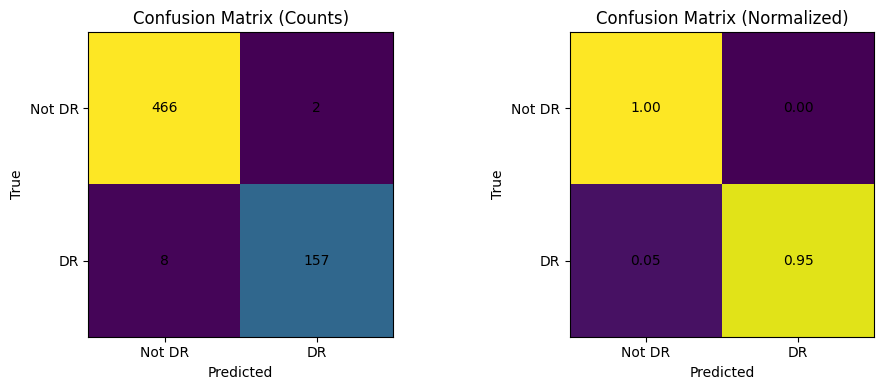

Saved: export_dr_model/plots/confusion_matrix.png


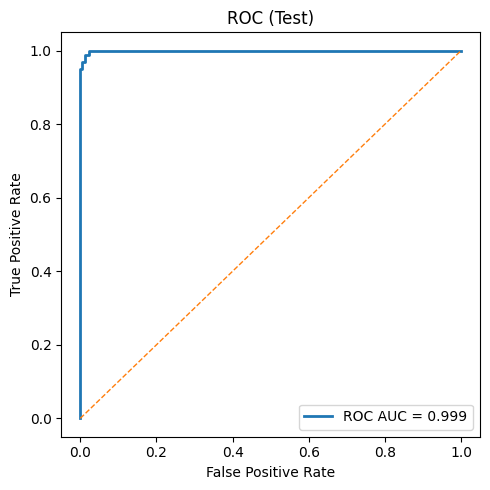

Saved: export_dr_model/plots/roc_test.png


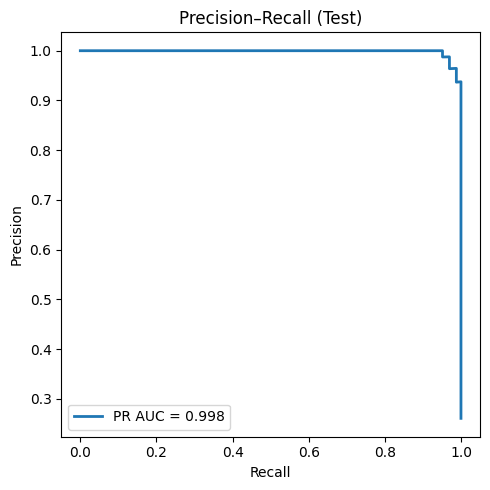

Saved: export_dr_model/plots/pr_test.png

Classification report @ threshold = 0.7307
              precision    recall  f1-score   support

      Not DR       0.98      1.00      0.99       468
          DR       0.99      0.95      0.97       165

    accuracy                           0.98       633
   macro avg       0.99      0.97      0.98       633
weighted avg       0.98      0.98      0.98       633

Saved: export_dr_model/plots/classification_report.txt


In [18]:
# === Create & save Confusion Matrix, ROC, PR plots on TEST set ===
import numpy as np, matplotlib.pyplot as plt, os
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)

PLOTS_DIR = os.path.join(EXPORT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

# Single-shot predictions on test
y_prob_test = model.predict(test_ds, verbose=1).ravel()
y_true_test = np.concatenate([yb.numpy() for _, yb in test_ds]).astype(int)

# Use your chosen operating threshold
thr = float(best_thr_exact) if 'best_thr_exact' in globals() else 0.5
y_pred_test = (y_prob_test >= thr).astype(int)

# ---- Confusion Matrix (counts + normalized) ----
cm = confusion_matrix(y_true_test, y_pred_test, labels=[0,1])  # rows=true [NotDR, DR], cols=pred
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

# Counts
im0 = ax[0].imshow(cm, interpolation='nearest')
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted'); ax[0].set_ylabel('True')
ax[0].set_xticks([0,1]); ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['Not DR','DR']); ax[0].set_yticklabels(['Not DR','DR'])
for i in range(2):
    for j in range(2):
        ax[0].text(j, i, cm[i, j], ha='center', va='center')

# Normalized
im1 = ax[1].imshow(cm_norm, interpolation='nearest')
ax[1].set_title('Confusion Matrix (Normalized)')
ax[1].set_xlabel('Predicted'); ax[1].set_ylabel('True')
ax[1].set_xticks([0,1]); ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['Not DR','DR']); ax[1].set_yticklabels(['Not DR','DR'])
for i in range(2):
    for j in range(2):
        ax[1].text(j, i, f"{cm_norm[i, j]:.2f}", ha='center', va='center')

plt.tight_layout()
CM_PNG = os.path.join(PLOTS_DIR, "confusion_matrix.png")
plt.savefig(CM_PNG, dpi=200)
plt.show()
print("Saved:", CM_PNG)

# ---- ROC curve ----
fpr, tpr, _ = roc_curve(y_true_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC (Test)')
plt.legend(); plt.tight_layout()
ROC_PNG = os.path.join(PLOTS_DIR, "roc_test.png")
plt.savefig(ROC_PNG, dpi=200)
plt.show()
print("Saved:", ROC_PNG)

# ---- Precision–Recall curve ----
prec, rec, _ = precision_recall_curve(y_true_test, y_prob_test)
pr_auc = auc(rec, prec)

plt.figure(figsize=(5,5))
plt.plot(rec, prec, lw=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall (Test)')
plt.legend(); plt.tight_layout()
PR_PNG = os.path.join(PLOTS_DIR, "pr_test.png")
plt.savefig(PR_PNG, dpi=200)
plt.show()
print("Saved:", PR_PNG)

# ---- Classification report (printed and saved) ----
report = classification_report(y_true_test, y_pred_test, target_names=["Not DR","DR"])
print("\nClassification report @ threshold =", thr)
print(report)
with open(os.path.join(PLOTS_DIR, "classification_report.txt"), "w") as f:
    f.write(f"Threshold: {thr}\n\n{report}")
print("Saved:", os.path.join(PLOTS_DIR, "classification_report.txt"))
